In [1]:
%%capture
!pip install datasets torch torchvision torchaudio transformers evaluate numpy rouge_score tensorboard matplotlib

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, Seq2SeqTrainer , Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, EarlyStoppingCallback
import evaluate
import torch
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import gc
import numpy as np

2025-06-22 08:17:34.940774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750580255.125252      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750580255.180202      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# MODEL_NAME = "google/mt5-base"
# MODEL_NAME = "facebook/mbart-large-50"
# MODEL_NAME = "bigscience/bloom-560m"
MODEL_NAME = "facebook/mbart-large-50"
MAX_LEN = 512
TOTAL_BACTH_SIZE = 16
TRAIN_BATCH_SIZE = 2
VAL_BATCH_SIZE = 1
TEST_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 2e-5
CACHE_DATASET = "./datas/summary"
CACHE_MODEL = f"./models/{MODEL_NAME}"
LOG_DIR = f"./logs/{MODEL_NAME}"
SIZE = 1000

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = load_dataset("nhantruongcse/summary-vietnamese-news", cache_dir=CACHE_DATASET)

dataset

README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/161M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/164573 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Content', 'Summary'],
        num_rows: 164573
    })
})

In [6]:
TRAIN_SIZE = int(SIZE * 0.8)
TEST_SIZE = int(SIZE * 0.2)
train_dataset_raw = dataset['train'].select(range(TRAIN_SIZE))
val_dataset_raw = dataset['train'].select(range(TRAIN_SIZE, SIZE))
test_dataset_raw = dataset['train'].select(range(SIZE, SIZE + TEST_SIZE))

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_MODEL)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, cache_dir=CACHE_MODEL).to(device)

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [8]:
# Show parameters
total_params = model.num_parameters()
print(f"Total parameters in the model: {total_params:,}")

Total parameters in the model: 610,879,488


In [9]:
def preprocessing(example_batch):
    inputs = [content for content in example_batch['Content']]
    
    input_encodings = tokenizer(
        inputs,
        max_length=MAX_LEN,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
    
    target_encodings = tokenizer(
        example_batch['Summary'],
        max_length=MAX_LEN // 4,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [10]:
train_dataset = train_dataset_raw.map(preprocessing, batched=True, remove_columns=["Content", "Summary"])
val_dataset = val_dataset_raw.map(preprocessing, batched=True,remove_columns=["Content", "Summary"])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [11]:
rouge_metric = evaluate.load("rouge")
def compute_metrics(eval_pred):
    global tokenizer
    if tokenizer is None:
        raise ValueError("Tokenizer must be provided globally or within the function")

    predictions, labels = eval_pred

    valid_decoded_preds = []
    valid_decoded_labels = []

    for pred, label in zip(predictions, labels):
        try:
            decoded_pred = tokenizer.decode(pred, skip_special_tokens=True)
            decoded_label = tokenizer.decode(label, skip_special_tokens=True)
            valid_decoded_preds.append(decoded_pred)
            valid_decoded_labels.append(decoded_label)
        except (UnicodeDecodeError, OverflowError) as e:
            continue

    if not valid_decoded_preds:
        return {"rouge": 0.0}

    result = rouge_metric.compute(
        predictions=valid_decoded_preds,
        references=valid_decoded_labels,
        use_stemmer=True
    )

    return result

In [12]:
data_collator=DataCollatorForSeq2Seq(model=model, tokenizer=tokenizer)

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"./models/{MODEL_NAME}-finetuned",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VAL_BATCH_SIZE,
    gradient_accumulation_steps=TOTAL_BACTH_SIZE // TRAIN_BATCH_SIZE,
    eval_accumulation_steps=TOTAL_BACTH_SIZE // VAL_BATCH_SIZE,
    warmup_steps=TRAIN_BATCH_SIZE * 10,
    eval_steps=1.2 * SIZE//TOTAL_BACTH_SIZE,
    save_steps=1.2 * SIZE//TOTAL_BACTH_SIZE,
    weight_decay=0.01,
    logging_dir=LOG_DIR,
    logging_steps=1.2 * SIZE//(TOTAL_BACTH_SIZE * 2),
    eval_strategy="steps",
    logging_strategy="steps",
    save_strategy="steps",
    learning_rate=LEARNING_RATE,
    fp16=False,
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    report_to=["tensorboard"],
    load_best_model_at_end = True,
    predict_with_generate=True,
    save_total_limit=1,
)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(optimizer, None)
)

In [14]:
trainer.train()

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
75,5.637100,4.477387,0.036486,0.016486,0.023543,0.023351
150,3.071300,2.777419,0.032312,0.013401,0.020851,0.021002


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=150, training_loss=5.255148537953695, metrics={'train_runtime': 1607.8316, 'train_samples_per_second': 1.493, 'train_steps_per_second': 0.093, 'total_flos': 2600555721523200.0, 'train_loss': 5.255148537953695, 'epoch': 3.0})

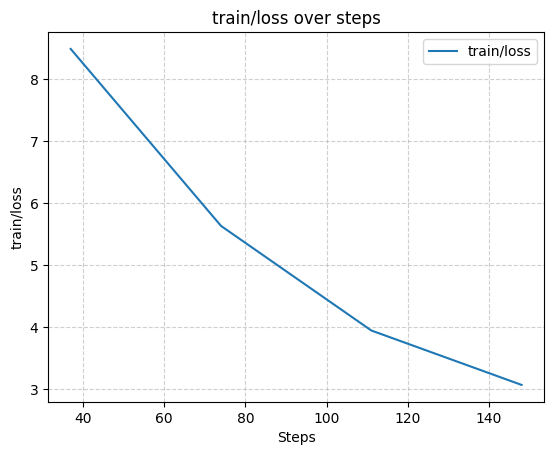

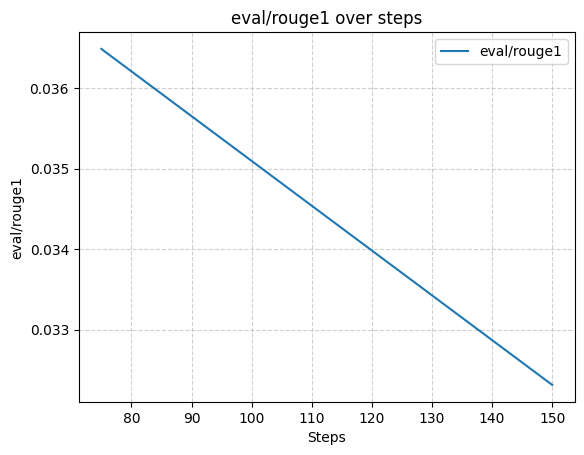

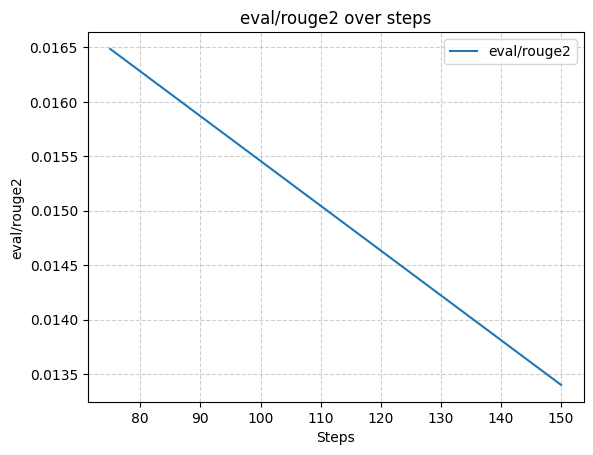

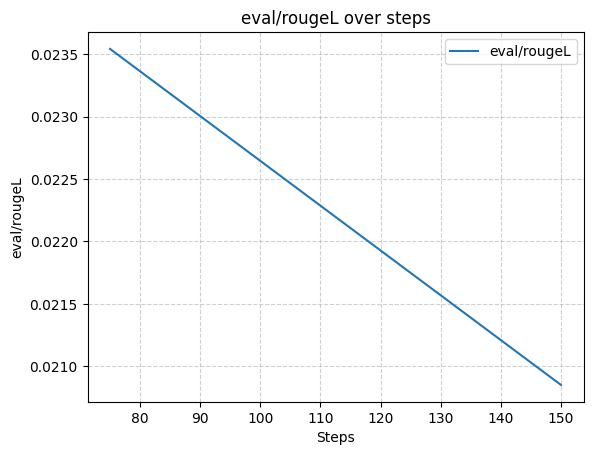

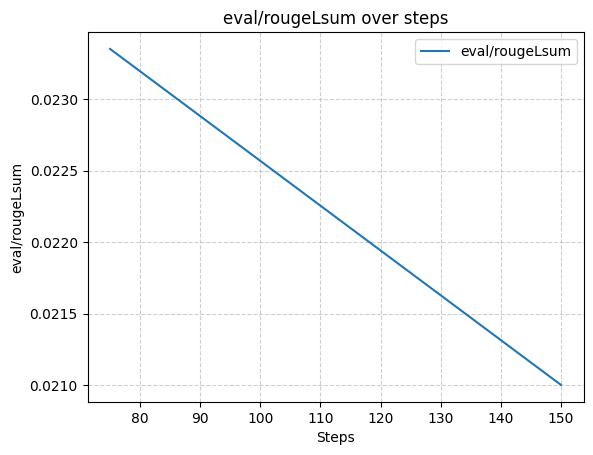

In [15]:
log_dir = LOG_DIR
event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events")]

scalars = {}
for file in event_files:
    event_acc = EventAccumulator(file)
    event_acc.Reload()
    tags = event_acc.Tags()["scalars"]
    for tag in tags:
        events = event_acc.Scalars(tag)
        values = [event.value for event in events]
        steps = [event.step for event in events]
        if tag not in scalars:
            scalars[tag] = {"steps": steps, "values": values}
        else:
            scalars[tag]["steps"].extend(steps)
            scalars[tag]["values"].extend(values)

metrics_to_plot = ["train/loss", "eval/rouge1", "eval/rouge2", "eval/rougeL", "eval/rougeLsum"]

for metric in metrics_to_plot:
    if metric in scalars:
        steps = scalars[metric]["steps"]
        values = scalars[metric]["values"]

        sorted_pairs = sorted(zip(steps, values))
        steps, values = zip(*sorted_pairs)
        
        plt.plot(steps, values, label=metric)
        plt.xlabel("Steps")
        plt.ylabel(metric)
        plt.title(f"{metric} over steps")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print(f"Metric {metric} not found in logs.")

In [16]:
def evaluate_rouge_on_test(model, tokenizer, test_dataset_raw, batch_size=4):
    import numpy as np
    from tqdm import tqdm
    
    model.eval()
    
    predictions = []
    references = []
    
    print(f"Đánh giá ROUGE trên {len(test_dataset_raw)} mẫu test...")
    
    for i in tqdm(range(0, len(test_dataset_raw), batch_size)):
        batch = test_dataset_raw.select(range(i, min(i + batch_size, len(test_dataset_raw))))
        
        batch_predictions = []
        batch_references = []
        
        for example in batch:
            input_text = example['Content']
            reference_summary = example['Summary']

            inputs = tokenizer.encode(
                input_text, 
                return_tensors="pt", 
                max_length=MAX_LEN, 
                truncation=True
            ).to(device)
            
            with torch.no_grad():
                outputs = model.generate(
                    inputs,
                    max_new_tokens=MAX_LEN // 4,
                    num_beams=4,
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                    length_penalty=1.0,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            
            # Decode prediction
            predicted_summary = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
            
            batch_predictions.append(predicted_summary)
            batch_references.append(reference_summary)
        
        predictions.extend(batch_predictions)
        references.extend(batch_references)
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    rouge_results = rouge_metric.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )
    
    pred_lengths = [len(pred.split()) for pred in predictions]
    ref_lengths = [len(ref.split()) for ref in references]
    
    print("\n" + "="*50)
    print("KẾT QUẢ ĐÁNH GIÁ ROUGE TRÊN TẬP TEST")
    print("="*50)
    print(f"Số lượng mẫu test: {len(predictions)}")
    print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")
    print(f"ROUGE-Lsum: {rouge_results['rougeLsum']:.4f}")
    print(f"Độ dài trung bình prediction: {np.mean(pred_lengths):.1f} từ")
    print(f"Độ dài trung bình reference: {np.mean(ref_lengths):.1f} từ")
    print(f"Tỷ lệ compression: {np.mean(pred_lengths) / np.mean(ref_lengths):.2f}")
    
    return {
        'rouge_scores': rouge_results,
        'predictions': predictions,
        'references': references,
        'pred_lengths': pred_lengths,
        'ref_lengths': ref_lengths
    }

In [17]:
def show_sample_results(results, num_samples=5):
    predictions = results['predictions']
    references = results['references']
    
    print("\n" + "="*50)
    print("MỘT SỐ VÍ DỤ KẾT QUẢ SUMMARIZATION")
    print("="*50)
    
    for i in range(min(num_samples, len(predictions))):
        print(f"\n--- VÍ DỤ {i+1} ---")
        print(f"Reference Summary:")
        print(f"{references[i]}")
        print(f"\nPredicted Summary:")
        print(f"{predictions[i]}")
        print(f"\nĐộ dài - Reference: {len(references[i].split())} từ, Predicted: {len(predictions[i].split())} từ")
        print("-" * 80)

results = evaluate_rouge_on_test(model, tokenizer, test_dataset_raw, batch_size=TEST_BATCH_SIZE)

show_sample_results(results, num_samples=10)

Đánh giá ROUGE trên 200 mẫu test...


100%|██████████| 100/100 [05:35<00:00,  3.35s/it]



KẾT QUẢ ĐÁNH GIÁ ROUGE TRÊN TẬP TEST
Số lượng mẫu test: 200
ROUGE-1: 0.1070
ROUGE-2: 0.0373
ROUGE-L: 0.0762
ROUGE-Lsum: 0.0764
Độ dài trung bình prediction: 78.0 từ
Độ dài trung bình reference: 38.1 từ
Tỷ lệ compression: 2.05

MỘT SỐ VÍ DỤ KẾT QUẢ SUMMARIZATION

--- VÍ DỤ 1 ---
Reference Summary:
Hình ảnh 15 chiếc ô tô tang vật, trong đó có đến 14 chiếc vận chuyển 50 tấn đường, được đưa vào trụ sở Công an H.Đakrông (Quảng Trị) hôm 29.10 thực sự làm nhiều người sốc vì quy mô của đường dây buôn lậu này.

Predicted Summary:
خودروی سواری اللبنانية اللبنانية السورية الزراعية الزراعية اللبنانية الزراعية المحتلة المحتلة اللبنانية المحتلة الزراعيةځایهეხოეხო الحرمين الحرمين الشريفین المحتلة الحرمين النبوي الشريفينه المحتلة جازا جازا مانشستر مانشستر يونايتد اللبنانية الحرمين اللبنانيةافات یارانهហារ فاعل فاعل يؤثر يؤثر بتوانیم بتوانیمനിബന്ധന ملکوں ملکوں الحرمين المحتلة صنعاء المحتلة شهيدদানഞ്ഞിВОЈВОЈҒАНҒАН RAKYAT DAERAH DAERAH KABUPATEN MERKEZ MERKEZЫЛДЫЫЛДЫДАРЫДАРЫВОЈДАРЫ KUTOKA KUTOKA SEKOLAH 

In [18]:
gc.collect()
torch.cuda.empty_cache()
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")

Number of GPUs available: 1
GPU 0: Tesla P100-PCIE-16GB
Memory Allocated: 7008.17 MB
Memory Cached: 7236.00 MB
